### 4월 이후를 예측해보기

In [1]:
# 모델 불러오기
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size=6, hidden_size=30, num_layers=2, batch_first=True)
        self.fc = nn.Linear(30, 1)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x

In [2]:
# Load model
model = RNN()
model.load_state_dict(torch.load('rnn_model.pth'))

<All keys matched successfully>

In [3]:
# 모델 사용하기
# 1. 데이터 로드
import pandas as pd
import numpy as np

data = pd.read_csv('../../DATA/SMP_201004_202403_norm.csv')
data.head()

,날짜,통합,norm,denorm
0,2001-04-01,50.705398,-1.165759,50.705398
1,2001-05-01,52.552364,-1.123687,52.552364
2,2001-06-01,51.247385,-1.153413,51.247385
3,2001-07-01,47.428339,-1.240408,47.428339
4,2001-08-01,42.293200,-1.357382,42.293200


In [4]:
# 마지막 6개월
data_6 = data.iloc[-6:]
data_6

,날짜,통합,norm,denorm
270,2023-10-01,137.01,0.800191,137.01
271,2023-11-01,120.85,0.432079,120.85
272,2023-12-01,131.12,0.666022,131.12
273,2024-01-01,138.06,0.824110,138.06
274,2024-02-01,119.53,0.402011,119.53
275,2024-03-01,134.47,0.742332,134.47


In [5]:
# model prediction
# norm column으로 예측
norm = torch.tensor(data_6['norm'].values).unsqueeze(0).float()
norm, norm.shape


(tensor([[0.8002, 0.4321, 0.6660, 0.8241, 0.4020, 0.7423]]),
 torch.Size([1, 6]))

In [6]:
pred = model(norm.unsqueeze(0))
pred

tensor([[0.4533]], grad_fn=<AddmmBackward0>)

In [7]:
def denorms(x):
    return x * 43.89968 + 101.88185

In [8]:
print('4월 예측 가중평균 SMP :',denorms(pred).item())

4월 예측 가중평균 SMP : 121.78291320800781


실제 데이터는?

In [9]:
# Load data
data_april = pd.read_csv('../../DATA/HOME_전력거래_계통한계가격_시간별SMP_4월_일별.csv', encoding='cp949')
data_april.head()

,기간,01시,02시,03시,04시,05시,06시,07시,08시,09시,...,18시,19시,20시,21시,22시,23시,24시,최대,최소,가중평균
0,2024/04/14,99.52,94.96,86.66,86.65,86.68,100.28,99.37,94.77,95.19,...,118.20,119.00,141.75,139.71,119.84,119.08,98.50,141.75,86.65,106.62
1,2024/04/13,100.36,92.86,86.90,86.90,86.90,100.94,101.13,92.86,96.25,...,97.82,98.06,98.32,98.83,99.09,99.60,111.31,111.31,86.90,96.92
2,2024/04/12,101.85,99.08,87.57,87.34,87.57,95.88,102.01,101.85,137.41,...,97.41,98.42,99.08,99.18,99.44,99.29,99.98,148.26,87.34,109.42
3,2024/04/11,102.01,96.31,86.93,85.92,86.93,96.31,102.32,113.53,158.09,...,128.39,141.14,142.30,141.05,114.74,141.61,116.33,164.20,85.92,123.75
4,2024/04/10,117.35,102.40,95.98,95.95,99.16,149.78,149.95,149.88,110.38,...,110.69,147.73,147.74,147.75,147.74,147.77,142.26,150.28,95.95,129.34


In [10]:
# 가중평균 구하기
means = data_april['가중평균'].mean()
means

121.20928571428574

### 앞으로 6개월 ~ 1년의 데이터를 구해보기

1. 마지막 6개월 데이터로 4월 예측
2. 4월 예측을 포함한 데이터로 5월 예측
3. 이렇게 쭉쭉

In [32]:
# 
initial = data['norm'].values[-6:]
initial, initial.shape

(array([0.80019138, 0.43207937, 0.66602184, 0.82410955, 0.40201082,
        0.74233219]),
 (6,))

In [33]:
# 예측값
# - initial 입력
# - pred 예측값 저장
# - initial에 pred 추가
# - 반복

pred_length = 12

for i in range(pred_length):
    values = torch.tensor(initial[-6:]).unsqueeze(0).float()
    print(values.shape)
    pred = model(values.unsqueeze(0))
    initial = np.append(initial, pred.item())

print(initial)

torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
[0.80019138 0.43207937 0.66602184 0.82410955 0.40201082 0.74233219
 0.45333055 0.24567392 0.328592   0.39519209 0.33297026 0.72449422
 0.55607569 0.88320744 0.91682708 1.25021636 1.49687338 1.40867496]


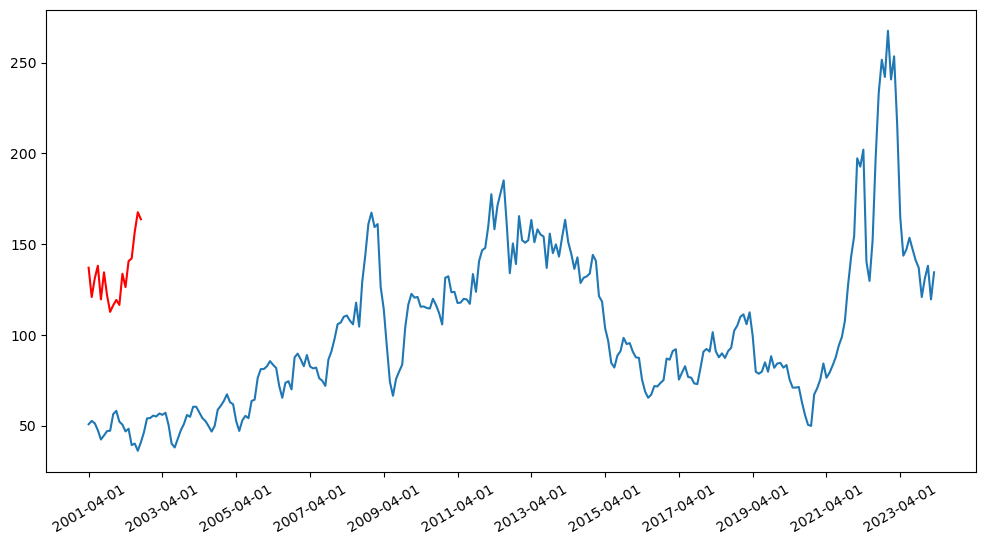

In [54]:
# 예측값 denorm, 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
# data plot
# - denorm column, x축은 날짜, y축은 SMP 가격
plt.plot(data['날짜'], data['denorm'], label='SMP')
plt.xticks(range(0, len(data), 24), data['날짜'][::24], rotation=30)
# pred plot
# - denorm column, x축은 날짜, y축은 SMP 가격
# - x축은 가장 마지막 날짜부터 12개월 예측
denorm_init = denorms(initial).tolist()
plt.plot(denorm_init, 'r-', label='Prediction')

plt.show()

In [68]:
# 날짜 인덱스 생성 : 2001/03 ~ 2024/03 (월만 표현)
date_index = pd.date_range(start='2001-04-01', freq='M', periods=len(data))
date_index

# 데이터 생성 및 시각화
data['date'] = date_index
data.head(), data.tail()

(           날짜         통합      norm     denorm       date
 0  2001-04-01  50.705398 -1.165759  50.705398 2001-04-30
 1  2001-05-01  52.552364 -1.123687  52.552364 2001-05-31
 2  2001-06-01  51.247385 -1.153413  51.247385 2001-06-30
 3  2001-07-01  47.428339 -1.240408  47.428339 2001-07-31
 4  2001-08-01  42.293200 -1.357382  42.293200 2001-08-31,
              날짜      통합      norm  denorm       date
 271  2023-11-01  120.85  0.432079  120.85 2023-11-30
 272  2023-12-01  131.12  0.666022  131.12 2023-12-31
 273  2024-01-01  138.06  0.824110  138.06 2024-01-31
 274  2024-02-01  119.53  0.402011  119.53 2024-02-29
 275  2024-03-01  134.47  0.742332  134.47 2024-03-31)

In [64]:
# 예측 데이터 생성
pred_date_index = pd.date_range(start='2024-04-01', freq='M', periods=pred_length)
pred_date_index

DatetimeIndex(['2024-04-30', '2024-05-31', '2024-06-30', '2024-07-31',
               '2024-08-31', '2024-09-30', '2024-10-31', '2024-11-30',
               '2024-12-31', '2025-01-31', '2025-02-28', '2025-03-31'],
              dtype='datetime64[ns]', freq='M')

In [67]:
pred_data = pd.DataFrame({ 'date': pred_date_index, 'denorm': denorm_init[-pred_length:]})
pred_data

,date,denorm
0,2024-04-30,121.782916
1,2024-05-31,112.666857
2,2024-06-30,116.306934
3,2024-07-31,119.230656
4,2024-08-31,116.499138
5,2024-09-30,133.686914
6,2024-10-31,126.293395
7,2024-11-30,140.654374
8,2024-12-31,142.130266
9,2025-01-31,156.765948


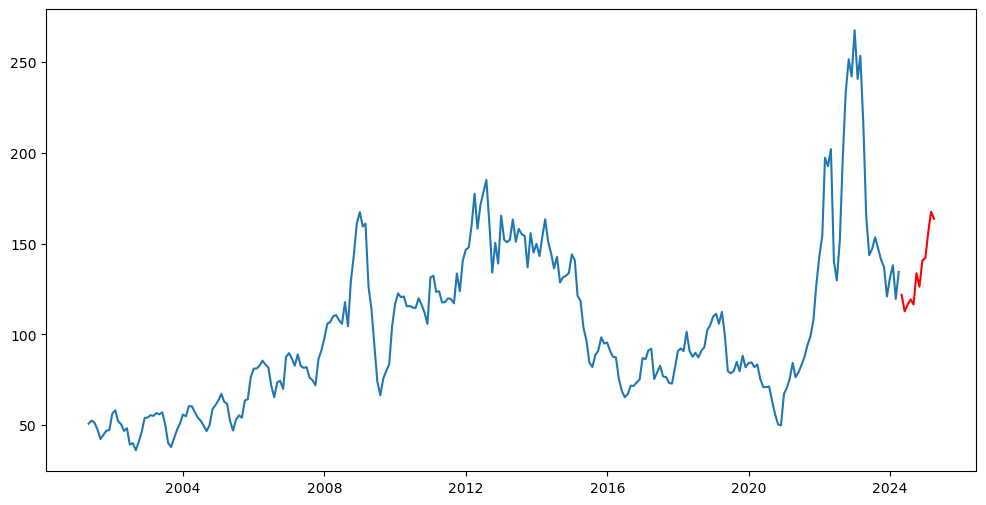

In [70]:
# 시각화
plt.figure(figsize=(12, 6))
# data plot
plt.plot(data['date'], data['denorm'], label='SMP')
plt.xticks(rotation=0)
# pred plot
plt.plot(pred_data['date'], pred_data['denorm'], 'r-', label='Prediction')
plt.show()

### 큰 틀은 잘 짰으니 처음부터 넣어보자

In [73]:
pred_total = data['norm'][:6]
pred_length = 12
for i in range(pred_length):
    values = torch.tensor(pred_total[-6:]).unsqueeze(0).float()
    pred = model(values.unsqueeze(0))
    pred_total = np.append(pred_total, pred.item())

print(pred_total)
pred_total_denorm = denorms(pred_total).tolist()
print(pred_total_denorm)

[-1.16575911 -1.12368669 -1.15341308 -1.24040792 -1.35738233 -1.30618676
 -1.25133216 -1.17482913 -1.03975821 -1.03295863 -1.01985967 -1.03022587
 -1.0669378  -1.11769247 -1.09361196 -1.00142622 -0.91237342 -0.7946018 ]
[50.705398147716146, 52.55236408564794, 51.24738468682304, 47.42833920547231, 42.29319991025461, 44.540669304692265, 46.94876843500138, 50.30722734006882, 56.23679750495911, 56.5352968325615, 57.11033677217484, 56.65526384786606, 55.043621814746864, 52.815508204422, 53.87263510311127, 57.91955940101624, 61.828948664493566, 66.99908533784867]


In [80]:
# 예측 데이터 생성
pred_total_date_index = pd.date_range(start='2001-10-01', freq='M', periods=pred_length)    # 2001-04 ~ 09 6개월은 학습
pred_df = pd.DataFrame({'date': pred_total_date_index, 'denorm': pred_total_denorm[-pred_length:]})
pred_df


,date,denorm
0,2001-10-31,46.948768
1,2001-11-30,50.307227
2,2001-12-31,56.236798
3,2002-01-31,56.535297
4,2002-02-28,57.110337
5,2002-03-31,56.655264
6,2002-04-30,55.043622
7,2002-05-31,52.815508
8,2002-06-30,53.872635
9,2002-07-31,57.919559


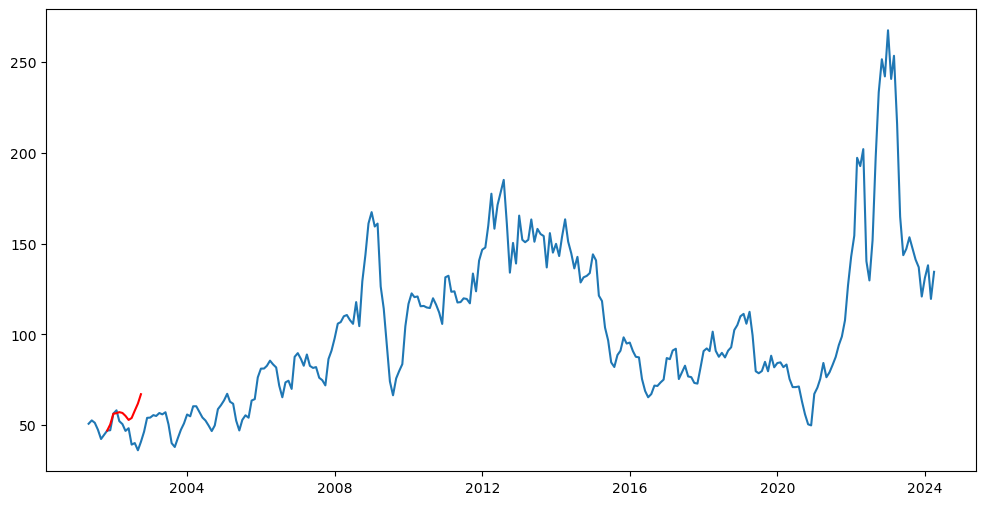

In [81]:
# 시각화
plt.figure(figsize=(12, 6))
# data plot
plt.plot(data['date'], data['denorm'], label='SMP')
plt.xticks(rotation=0)
# pred plot
plt.plot(pred_df['date'], pred_df['denorm'], 'r-', label='Prediction')
plt.show()

In [83]:
# 어... 이제 23년간을 예측하기
pred_total = data['norm'][:6]
pred_length = 276
for i in range(pred_length):
    values = torch.tensor(pred_total[-6:]).unsqueeze(0).float()
    pred = model(values.unsqueeze(0))
    pred_total = np.append(pred_total, pred.item())
    
# print(pred_total)
pred_total_denorm = denorms(pred_total).tolist()
# print(pred_total_denorm)

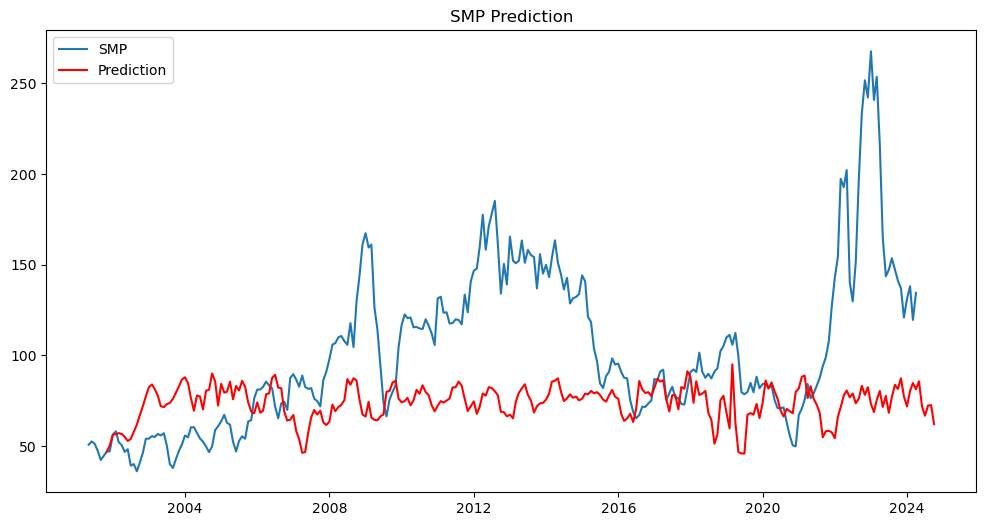

In [85]:
# 예측 데이터 생성
pred_total_date_index = pd.date_range(start='2001-10-01', freq='M', periods=pred_length)    # 2001-04 ~ 09 6개월은 학습
pred_df = pd.DataFrame({'date': pred_total_date_index, 'denorm': pred_total_denorm[-pred_length:]})

# 시각화
plt.figure(figsize=(12, 6))
# data plot
plt.plot(data['date'], data['denorm'], label='SMP')
plt.xticks(rotation=0)
# pred plot
plt.plot(pred_df['date'], pred_df['denorm'], 'r-', label='Prediction')
plt.title('SMP Prediction')
plt.legend()
plt.show()